# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model
1. Learn how to deploy and use a text model on CAIP


## Introduction


In this notebook, we will implement text models to recognize the probable source (GitHub, TechCrunch, or The New York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os
import warnings

import pandas as pd
from google.cloud import bigquery

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set `PATH` to include the directory containing saved_model_cli
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.:/home/jupyter/.local/bin:.


Replace the variable values in the cell below:

In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,http://www.nytimes.com/2009/12/13/business/13n...,Can Nokia Recapture Its Glory Days?,11
1,http://dogfoodconnoisseur.blogspot.com/2015/07...,"“That's not a compiler, I don't pay you to des...",11
2,http://www.nytimes.com/2009/12/13/opinion/13fr...,The Do-It-Yourself Economy,11
3,http://www.nytimes.com/2015/05/10/technology/a...,An App That Helps Drivers Earn the Most from T...,11
4,http://go-talks.appspot.com/github.com/daveche...,High performance servers without the event loop,11
5,http://computationallegalstudies.com/2009/12/1...,"Movie: Visualizing Bank Failures, 2008 - 2009",11
6,http://devblogs.nvidia.com/parallelforall/gpus...,Faster Epidemic Forecasting on GPUs,11
7,http://www.ktvu.com/news/15054540/detail.html,Has E.T. Made A Call? (Possible Contact from I...,11
8,https://blog.mozilla.org/blog/2015/07/23/mdn-c...,MDN celebrates 10 years of documenting Your Web,11
9,http://www.newyorker.com/magazine/2015/07/27/t...,The Right Poem: When Pundits Refer to Plato,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,185356
1,medium,134533
2,youtube,130150
3,nytimes,85178
4,blogspot,62189
...,...,...
95,nextplatform,3169
96,itworld,3161
97,atlasobscura,3082
98,anandtech,3015


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = ".*://(.[^/]+)/"


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(
    regex
)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(
    sub_query=sub_query
)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,mandelbrot fractal generated by your pdf viewer,github
1,compiler from ejs underscore or simply html to...,github
2,canadarm a javascript logger that works for you,github
3,automate appium tests suite for cordova apps,github
4,hacking team leaked repos on github,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print(f"The full dataset contains {len(title_dataset)} titles")

The full dataset contains 330460 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        185356
nytimes        85178
techcrunch     59926
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = "./data/"

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = "titles_full.csv"
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding="utf-8"
)

In [12]:
import datetime
import os
import shutil

import keras
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Input, Lambda, TextVectorization
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow_hub import KerasLayer

# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2025-08-18 19:00:36.772189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755543637.269773   10713 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755543637.408058   10713 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.1


In [13]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [14]:
MODEL_DIR = f"gs://{BUCKET}/text_models"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, TechCrunch, or The New York Times):

In [15]:
ls $DATADIR

titles_full.csv


In [16]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATADIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,transcript ezra klein interviews dario amodei...,nytimes
1,langchain for go the easiest way to write llm...,github
2,mdma therapy inches closer to approval,nytimes
3,wolfram alpha added to bing,nytimes
4,google cancels half the projects at its intern...,techcrunch


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [17]:
titles_df.source.value_counts()

source
github        185356
nytimes        85178
techcrunch     59926
Name: count, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [18]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [19]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [20]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Preparing the train/test splits

Let's split our data into train and test splits:

In [21]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [22]:
sources_train.value_counts()

source
github        176104
nytimes        80918
techcrunch     56915
Name: count, dtype: int64

In [23]:
sources_valid.value_counts()

source
github        9252
nytimes       4260
techcrunch    3011
Name: count, dtype: int64

Now let's create the features and labels we will feed our models with:

In [24]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [25]:
X_train[:3]

array(['transcript  ezra klein interviews dario amodei  anthropic s ceo and co-founder',
       'langchain for go  the easiest way to write llm-based programs in go',
       'mdma therapy inches closer to approval'], dtype=object)

In [26]:
Y_train[:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [27]:
# TODO 1
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True
)

2025-08-18 19:00:55.288124: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [28]:
# TODO 1
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [29]:
# TODO 1
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True
)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [30]:
# TODO 1
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [48]:
def build_model(hub_module, name):
    model = Sequential(
        [
            hub_module,  # TODO 2
            Dense(16, activation="relu"),
            Dense(N_CLASSES, activation="softmax"),
        ],
        name=name,
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [43]:
# def build_model(hub_module, embedding_dim, name):
#     """
#     Builds a Keras model with a TF-Hub embedding layer.

#     Args:
#       hub_module: The loaded TF-Hub KerasLayer.
#       embedding_dim: The output dimension of the embedding layer.
#       name: The name for the model.

#     Returns:
#       A compiled Keras model.
#     """
#     input_layer = Input(shape=(), dtype=tf.string, name="text_input")

#     # Wrap the hub module in a Lambda layer and specify the output shape
#     embedding_layer = Lambda(
#         lambda x: hub_module(x, "nnlm"),
#         output_shape=(embedding_dim,) # Explicitly define the output shape
#     )(input_layer)

#     x = Dense(16, activation="relu")(embedding_layer)
#     output = Dense(N_CLASSES, activation="softmax")(x)

#     model = keras.Model(inputs=input_layer, outputs=output, name=name)

#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )
#     return model


import keras
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model


def build_model(hub_module, name):
    """
    Builds a Keras model with a TF-Hub embedding layer.
    """
    # Define the input layer for raw text strings
    input_layer = Input(shape=(), dtype=tf.string, name="text_input")

    # Apply the TF-Hub KerasLayer directly to the input
    embedding_layer = hub_module(input_layer)

    # Add the subsequent layers
    x = Dense(16, activation="relu")(embedding_layer)
    output = Dense(N_CLASSES, activation="softmax")(x)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output, name=name)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [49]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train,
        Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(patience=3), TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [50]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [51]:
nnlm_model = build_model(nnlm_module, "nnlm")
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7fc369aa4c70> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

<Axes: >

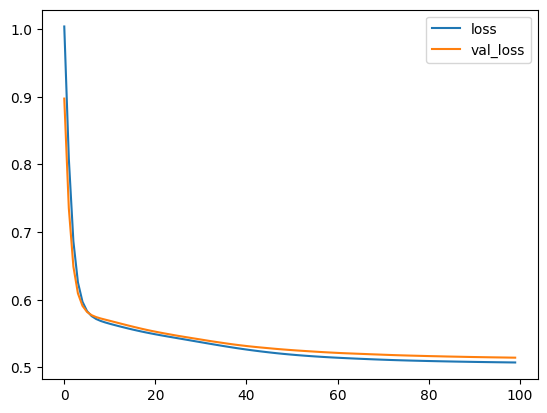

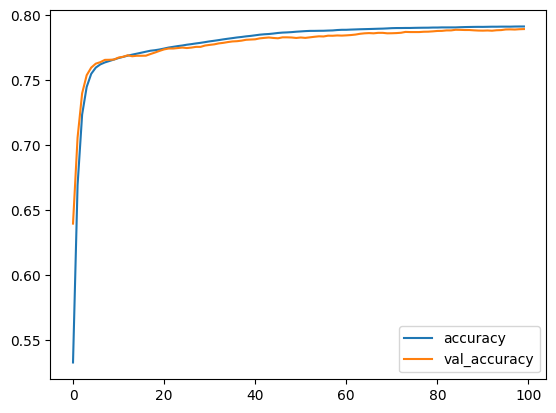

In [36]:
history = nnlm_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

## Training Swivel

In [37]:
swivel_model = build_model(swivel_module, 20, name="swivel")

In [38]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2669 - loss: 1.3059 - val_accuracy: 0.5635 - val_loss: 0.9828
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5971 - loss: 0.9360 - val_accuracy: 0.6386 - val_loss: 0.8506
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6438 - loss: 0.8359 - val_accuracy: 0.6576 - val_loss: 0.8069
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6596 - loss: 0.8008 - val_accuracy: 0.6676 - val_loss: 0.7857
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6681 - loss: 0.7826 - val_accuracy: 0.6741 - val_loss: 0.7728
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6738 - loss: 0.7709 - val_accuracy: 0.6779 - val_loss: 0.7645
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6773 - loss: 0.7631 - val_accuracy: 0.6806 - val_loss: 0.7586
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6805 - loss: 0.7575 - val_accuracy: 0.

<Axes: >

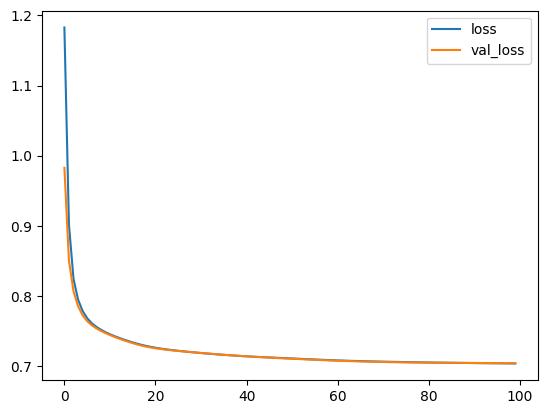

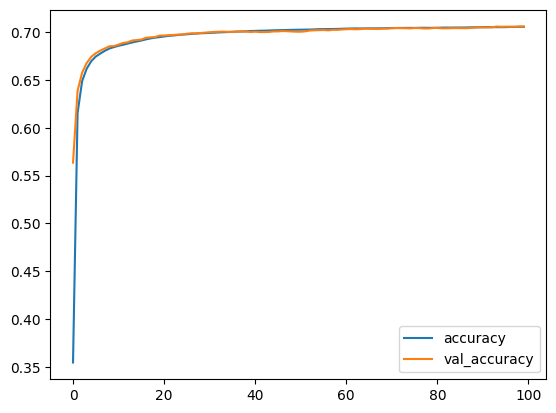

In [39]:
history = swivel_history
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

## Comparing the models

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

At last, let's compare all the models we have trained at once using TensorBoard in order
to choose the one that overfits the less for the same performance level.

Run the output of the following command in your Cloud Shell to launch TensorBoard, and use the Web Preview on port 6006 to view it.

In [40]:
!echo tensorboard --logdir $MODEL_DIR --port 6006

tensorboard --logdir gs://sanjana-sandbox-012024/text_models --port 6006


## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [42]:
OUTPUT_DIR = "./savedmodels_vertex"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, "swivel")
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_DISPLAY_NAME = f"title_model_{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"swivel_{TIMESTAMP}"
IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
ARTIFACT_DIRECTORY = f"gs://{BUCKET}/{MODEL_DISPLAY_NAME}/"
os.environ["EXPORT_PATH"] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

# tf.keras.models.save_model(swivel_model, EXPORT_PATH)
swivel_model.export(EXPORT_PATH)

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper___call___198421'
	Captured Tensor = <ResourceHandle(name="hash_table_<google3.third_party.tensorflow.python.training.tracking.tracking.TrackableAsset object at 0x7faef27d6ed0>_-2_-1_load_170_259", device="/job:localhost/replica:0/task:0/device:CPU:0", container="localhost", type="tensorflow::lookup::LookupInterface", dtype and shapes : "[  ]")>
	Trackable referencing this tensor = <tensorflow.python.trackable.resource.RestoredResource object at 0x7fc438c72d10>
	Internal Tensor = Tensor("198405:0", shape=(), dtype=resource)

Then we can deploy the model using the gcloud CLI as before:

In [ ]:
%%bash

# TODO 5

TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=title_model_$TIMESTAMP
ENDPOINT_DISPLAYNAME=swivel_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
ARTIFACT_DIRECTORY=gs://${BUCKET}/${MODEL_DISPLAYNAME}/
echo $ARTIFACT_DIRECTORY

gsutil cp -r ${EXPORT_PATH}/* ${ARTIFACT_DIRECTORY}

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$ARTIFACT_DIRECTORY \
    --format="value(model)")

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"

# Deployment
DEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2
MIN_REPLICA_COUNT=1
MAX_REPLICA_COUNT=3

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=$MIN_REPLICA_COUNT \
  --max-replica-count=$MAX_REPLICA_COUNT \
  --traffic-split=0=100

In [ ]:
import datetime
import os

from google.cloud import aiplatform

# --- Configuration (replace with your values) ---
# These are often derived from your environment, similar to the notebook.
# PROJECT = os.environ.get("PROJECT")
# BUCKET = os.environ.get("BUCKET")
# REGION = os.environ.get("REGION")

# Local path to your exported model directory
EXPORT_PATH = "./savedmodels_vertex/swivel"

# --- Initialize Vertex AI SDK ---
aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

# --- 1. Define Names and URIs ---
# This section corresponds to the variable definitions in your bash script.
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_DISPLAY_NAME = f"title_model_{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"swivel_{TIMESTAMP}"
IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
ARTIFACT_DIRECTORY = f"gs://{BUCKET}/{MODEL_DISPLAY_NAME}/"

print(f"Using artifact directory: {ARTIFACT_DIRECTORY}")

# Note: The original script uses `gsutil` to copy model files to GCS.
# The `aiplatform.Model.upload` function can upload from a local path,
# but it's often better to explicitly upload to a permanent GCS location first.
# For this script, we will assume the artifacts need to be in GCS as specified
# by ARTIFACT_DIRECTORY before calling upload.
print("Please ensure your model files are copied to the artifact directory.")
print(f"You can use: gsutil cp -r {EXPORT_PATH}/* {ARTIFACT_DIRECTORY}")


# --- 2. Upload the Model ---
# This replaces the `gcloud ai models upload` command.
print(f"Uploading model: {MODEL_DISPLAY_NAME}")
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=IMAGE_URI,
    artifact_uri=ARTIFACT_DIRECTORY,
)

print(f"Model uploaded. Resource name: {model.resource_name}")


# --- 3. Create an Endpoint ---
# This replaces the `gcloud ai endpoints create` command.
print(f"Creating endpoint: {ENDPOINT_DISPLAY_NAME}")
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

print(f"Endpoint created. Resource name: {endpoint.resource_name}")

# --- 4. Deploy the Model to the Endpoint ---
# This replaces the `gcloud ai endpoints deploy-model` command.
DEPLOYED_MODEL_DISPLAY_NAME = f"{MODEL_DISPLAY_NAME}_deployment"
MACHINE_TYPE = "n1-standard-2"
MIN_REPLICA_COUNT = 1
MAX_REPLICA_COUNT = 3

print(f"Deploying model to endpoint...")
endpoint.deploy(
    model=model,
    deployed_model_display_name=DEPLOYED_MODEL_DISPLAY_NAME,
    machine_type=MACHINE_TYPE,
    min_replica_count=MIN_REPLICA_COUNT,
    max_replica_count=MAX_REPLICA_COUNT,
    traffic_split={"0": 100},
)

print("Deployment complete.")
print(f"Endpoint resource name for predictions: {endpoint.resource_name}")

Note the `ENDPOINT_RESOURCENAME` above as you'll need it below for the prediction.

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [ ]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

Let's go ahead and hit our model:

In [ ]:
%%writefile input.json
{
    "instances": [
        {"keras_layer_1_input": "hello"}
    ]
}

Insert below the `ENDPOINT_RESOURCENAME` from the deployment code above.

In [ ]:
%%bash
ENDPOINT_RESOURCENAME= #TODO: insert the ENDPOINT_RESOURCENAME here from above
gcloud ai endpoints predict $ENDPOINT_RESOURCENAME \
  --region $REGION \
  --json-request input.json

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License